# Example usage for clustering in "movekit"

In [8]:
import movekit as mkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

### Read in CSV file and preprocess

In [12]:
# Enter path to CSV file
path = "./examples/datasets/fish-5.csv"

In [10]:
import os
os.chdir('..')
import src.movekit.io as imp
import src.movekit.feature_extraction as fe
import src.movekit.clustering as cl
from src.movekit.preprocess import preprocess, convert_measueres

In [13]:
# Read in CSV file and preprocess
data = imp.read_data(path)
preprocessed_data = mkit.preprocess(data)


 Number of missing values = y            0
x            0
animal_id    0
time         0
dtype: int64



In [14]:
# converting positional data into scale, defined by user
convert_measueres(preprocessed_data, x_min = 0, x_max = 100, y_min = 0, y_max = 100).head()

,time,animal_id,x,y
0,1,312,49.663862,84.937627
1,1,511,44.688738,87.375033
2,1,607,47.555424,82.312218
3,1,811,55.281665,83.650358
4,1,905,44.134850,92.457755


In [15]:
feats = fe.extract_features(preprocessed_data, fps = 1)

### Detecting outliers
Function performs detection of outliers, based on user's criteria, regarding features, method and share of outliers.

In [16]:
outs = fe.outlier_detection(feats)

# printing all rows where outliers are present
outs[outs.loc[:,"outlier"] == 1]

,time,animal_id,outlier,x,y,distance,average_speed,average_acceleration,direction,stopped
4381,877,511,1,64.024072,7.887287,0.645740,0.645740,0.007075,-1.570202,0
4946,990,511,1,84.668724,35.864372,0.989962,0.989962,-0.016970,85.181662,0
4951,991,511,1,84.777247,36.784482,0.926487,0.926487,-0.063475,83.273314,0
4956,992,511,1,84.925232,37.660356,0.888287,0.888287,-0.038200,80.410027,0


In [9]:
# same function, different parameters
other_outs = fe.outlier_detection(dataset = feats, features = ["average_speed", "average_acceleration"], contamination = 0.05, n_neighbors = 8, method = "median", metric = "euclidean")

# printing all rows where outliers are present
other_outs[other_outs.loc[:,"outlier"] == 1].head()

,time,animal_id,outlier,x,y,distance,average_speed,average_acceleration,direction,stopped
5,2,312,1,405.31,417.37,0.390512,0.390512,0.390512,-87.064327,1
8,2,811,1,445.48,412.26,0.459674,0.459674,0.459674,44.118596,1
1173,235,811,1,406.41,463.45,0.232594,0.232594,-0.248446,-115.463345,1
1597,320,607,1,134.78,411.23,2.682928,2.682928,-0.342316,-172.504142,0
1602,321,607,1,132.58,411.00,2.211990,2.211990,-0.470937,-174.031668,0


### Group-level Analysis

Below we perform Analysis on Group-Level. This consists of:
- A dynamic time warping matrix, 
- A clustering over time based on absolute features,
- The heading difference of each animal with respect to the current centroid
- The group - polarization for each timestep. 

#### Obtain a matrix, based on dynamic time warping
Each Animal-ID is displayed in the indices, the entries reflect the euclidean distances of the animal's trajectories.

In [5]:
dtw_matrix(preprocessed_data)

,312,511,607,811,905
312,0.000000,30843.085403,32859.600139,42461.524553,37916.447829
511,30843.085403,0.000000,26931.014323,47116.708116,20967.960073
607,32859.600139,26931.014323,0.000000,39859.787924,35711.718898
811,42461.524553,47116.708116,39859.787924,0.000000,38379.806433
905,37916.447829,20967.960073,35711.718898,38379.806433,0.000000


#### Time series clustering for absolute features
Function can also be executed without extracted features, performing a standard feature-extraction before.

In [6]:
feats = mkit.extract_features(preprocessed_data)

In [8]:
ts_cluster(feats, 3).head(13)

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,cluster,ClustCenter,centroid_distance,centroid_average_speed,centroid_average_acceleration,centroid_direction,centroid_stopped
0,1,312,405.29,417.76,0.000000,0.0,0.0,0.000000,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0,0.0,0.000000,0.0
1,1,511,369.99,428.78,0.000000,0.0,0.0,0.000000,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0,0.0,0.000000,0.0
2,1,607,390.33,405.89,0.000000,0.0,0.0,0.000000,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0,0.0,0.000000,0.0
3,1,811,445.15,411.94,0.000000,0.0,0.0,0.000000,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0,0.0,0.000000,0.0
4,1,905,366.06,451.76,0.000000,0.0,0.0,0.000000,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0,0.0,0.000000,0.0
5,2,312,405.31,417.37,0.390512,0.0,0.0,-87.064327,0,2,"[0.21761692167266206, 0.0, 0.0, -11.8146888653...",0.217617,0.0,0.0,-11.814689,0.0
6,2,511,370.01,428.82,0.044721,0.0,0.0,63.434949,0,2,"[0.21761692167266206, 0.0, 0.0, -11.8146888653...",0.217617,0.0,0.0,-11.814689,0.0
7,2,607,390.25,405.89,0.080000,0.0,0.0,180.000000,0,1,"[0.07999999999998408, 0.0, 0.0, 180.0, 0.0]",0.080000,0.0,0.0,180.000000,0.0
8,2,811,445.48,412.26,0.459674,0.0,0.0,44.118596,0,0,"[0.3298368986912307, 0.0, 0.0, 112.05929800170...",0.329837,0.0,0.0,112.059298,0.0
9,2,905,365.86,451.76,0.200000,0.0,0.0,180.000000,0,0,"[0.3298368986912307, 0.0, 0.0, 112.05929800170...",0.329837,0.0,0.0,112.059298,0.0


#### Getting the heading difference
Calculate the difference in degrees between the animal's direction and the centroid's direction for each timestep. Stronger gain in y gives positive difference, weaker gain in y gives negative difference, since constant y is defined to be 0 degrees.

In [10]:
get_heading_difference(feats).head(13)

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,x_centroid,y_centroid,medoid,distance_to_centroid,centroid_direction,heading_difference
0,1,312,405.29,417.76,0.000000,0.0,0.0,0.000000,0,395.364,423.226,312,11.331,NaN,NaN
1,1,511,369.99,428.78,0.000000,0.0,0.0,0.000000,0,395.364,423.226,312,25.975,NaN,NaN
2,1,607,390.33,405.89,0.000000,0.0,0.0,0.000000,0,395.364,423.226,312,18.052,NaN,NaN
3,1,811,445.15,411.94,0.000000,0.0,0.0,0.000000,0,395.364,423.226,312,51.049,NaN,NaN
4,1,905,366.06,451.76,0.000000,0.0,0.0,0.000000,0,395.364,423.226,312,40.901,NaN,NaN
5,2,312,405.31,417.37,0.390512,0.0,0.0,-87.064327,0,395.382,423.220,312,11.523,-18.434949,-68.629378
6,2,511,370.01,428.82,0.044721,0.0,0.0,63.434949,0,395.382,423.220,312,25.983,-18.434949,81.869898
7,2,607,390.25,405.89,0.080000,0.0,0.0,180.000000,0,395.382,423.220,312,18.074,-18.434949,-161.565051
8,2,811,445.48,412.26,0.459674,0.0,0.0,44.118596,0,395.382,423.220,312,51.283,-18.434949,62.553545
9,2,905,365.86,451.76,0.200000,0.0,0.0,180.000000,0,395.382,423.220,312,41.062,-18.434949,-161.565051


#### Computing polarization
Computing polarization of animals for each timestep. Value is between 0 and 1

In [11]:
compute_polarization(feats).head(13)

,time,animal_id,x,y,distance,average_speed,average_acceleration,direction,stopped,polarization
0,1,312,405.29,417.76,0.000000,0.0,0.0,0.000000,0,1.000000
1,1,511,369.99,428.78,0.000000,0.0,0.0,0.000000,0,1.000000
2,1,607,390.33,405.89,0.000000,0.0,0.0,0.000000,0,1.000000
3,1,811,445.15,411.94,0.000000,0.0,0.0,0.000000,0,1.000000
4,1,905,366.06,451.76,0.000000,0.0,0.0,0.000000,0,1.000000
5,2,312,405.31,417.37,0.390512,0.0,0.0,-87.064327,0,0.248837
6,2,511,370.01,428.82,0.044721,0.0,0.0,63.434949,0,0.248837
7,2,607,390.25,405.89,0.080000,0.0,0.0,180.000000,0,0.248837
8,2,811,445.48,412.26,0.459674,0.0,0.0,44.118596,0,0.248837
9,2,905,365.86,451.76,0.200000,0.0,0.0,180.000000,0,0.248837


#### Producing a voronoi diagram
Each timestep gets a voronoi object as well as the area of the voronoi - shape. Infinity, if respective animal is outmost in swarm.

Voronoi object contains the following attributes:

`.points`
- Coordinates of input points.

`.vertices`
- Coordinates of the Voronoi vertices.

`ridge_points`
- Indices of the points between which each Voronoi ridge lies.

`ridge_vertices`
- Indices of the Voronoi vertices forming each Voronoi ridge.

`regions`
- Indices of the Voronoi vertices forming each Voronoi region. -1 indicates vertex outside the Voronoi diagram.

`point_region`
- Index of the Voronoi region for each input point. If qhull option “Qc” was not specified, the list will contain -1 for points that are not associated with a Voronoi region.

`furthest_site`
- True if this was a furthest site triangulation and False if not.



In [13]:
vor_area, vor_objects = voronoi_diagram(preprocessed_data)

In [14]:
vor_area.head(13)

,time,animal_id,x,y,area_voronoi
0,1,312,405.29,417.76,2414.225693
1,1,511,369.99,428.78,inf
2,1,607,390.33,405.89,inf
3,1,811,445.15,411.94,inf
4,1,905,366.06,451.76,inf
5,2,312,405.31,417.37,2389.875725
6,2,511,370.01,428.82,inf
7,2,607,390.25,405.89,inf
8,2,811,445.48,412.26,inf
9,2,905,365.86,451.76,inf


#### Plotting exemplary voronoi diagram of 3rd timestep. 

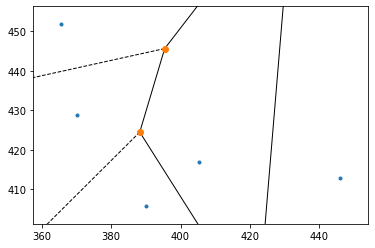

In [19]:
import matplotlib.pyplot as plt
voronoi_plot_2d(vor_objects[3])
plt.show()